In [1]:
##################################################################################
##### Define all parameters for model tuning
##################################################################################

n_fold = 5
expName = "NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_2"
outPath = "Results"
foldName = "folds.pickle"

epochs = 100
batch_size = 16
shuffle = True
seed = None

input_data_folder = "Data"
training_data_file = "Training-datasets-PredNTS.txt"
independent_data_file = "independent dataset-PredNTS.txt"

monitor = "val_accuracy"

In [2]:
import os 
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score, matthews_corrcoef

import math

import matplotlib.pyplot as plt

In [3]:
# print(tf.test.is_gpu_available(cuda_only=True))
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
##################################################################################
##### define all CUSTOM functions
##################################################################################

def one_hot_encode_nt(sequence, char_dict):
    
    seq_encoded = np.zeros((len(sequence),len(char_dict)))
    
    i = 0
    for single_character in sequence:
        if(single_character.upper() in char_dict.keys()):
            seq_encoded[i][char_dict[single_character.upper()]] = 1
            i = i+1
        else:
            raise ValueError('Incorrect character in NT sequence: '+sequence)
    return seq_encoded

In [5]:
##################################################################################
##### Build k-fold functions
##################################################################################

## Build the K-fold from dataset
def build_kfold(features, labels, k=10, shuffle=False, seed=None):
    
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
    kfoldList = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        kfoldList.append({
            "X_train": X_train,
            "X_test": X_test,
            "y_train":y_train,
            "y_test":y_test
        })
    return kfoldList

In [6]:
##################################################################################
##### define evaluator functions
##################################################################################

def pred2label(y_pred):
    y_pred = np.round(y_pred)
    return y_pred

In [7]:
# ##################################################################################
# ##### Function to customize the DLNN architecture with parameters
# ##################################################################################

# def DLNN_CORENup(input_seq_shape = (41, 21),
#                  conv_filters_per_layer_1 = 10, kernel_length_1 = 10, conv_strides_1 = 1, ## 1st Convolutional layer parameters
#                  max_pool_width_1 = 3, max_pool_stride_1 = 3, ## 1st Maxpool layer parameters
#                  lstm_decode_units = 15, ## LSTM layer parameters
#                  conv_filters_per_layer_2 = 10,  kernel_length_2 = 5, conv_strides_2 = 1, ## 2nd Convolutional layer parameters
#                  max_pool_width_2 = 3, max_pool_stride_2 = 3, ## 2nd Maxpool layer parameters
#                  dense_decode_units = 128, ## Dense layer parameters
#                  prob = 0.5, learn_rate = 0.0005, 
#                  loss = 'binary_crossentropy', metrics = 'accuracy'):
    
#     beta = 0.001
    
#     ######################################################################################################
#     ########  SEQUENCE  ##################################################################################
#     ######################################################################################################
    
#     input1 = tf.keras.layers.Input(shape=input_seq_shape)

#     x1 = tf.keras.layers.Conv1D(conv_filters_per_layer_1, kernel_length_1,
#                                 strides = conv_strides_1, kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                                 padding = "same")(input1)
#     x1 = tf.keras.layers.Activation('relu')(x1)
#     x1 = tf.keras.layers.MaxPool1D(pool_size = max_pool_width_1, strides = max_pool_stride_1)(x1)
#     x1 = tf.keras.layers.Dropout(prob)(x1)
    
#     x1 = tf.keras.layers.GaussianNoise(stddev=0.1)(x1)

#     ## LSTM Path

#     x2 = tf.keras.layers.LSTM(lstm_decode_units, return_sequences = True, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta))(x1)
    
#     x2 = tf.keras.layers.Dropout(prob)(x2)
    
#     x2 = tf.keras.layers.Flatten()(x2)
    
#     x2 = tf.keras.layers.GaussianNoise(stddev=0.1)(x2)

#     ## Conv Path

#     x3 = tf.keras.layers.Conv1D(conv_filters_per_layer_2, kernel_length_2, strides = conv_strides_2, 
#                                 kernel_regularizer = tf.keras.regularizers.l2(beta), padding = 'same')(x1)
#     x3 = tf.keras.layers.Activation('relu')(x3)
#     x3 = tf.keras.layers.MaxPooling1D(pool_size = max_pool_width_2, strides = max_pool_stride_2)(x3)
#     x3 = tf.keras.layers.Dropout(prob)(x3)
    
#     x3 = tf.keras.layers.Flatten()(x3)
    
#     x3 = tf.keras.layers.GaussianNoise(stddev=0.1)(x3)
    
#     x4 = tf.keras.layers.Concatenate(1)([x2,x3])
    
#     ######################################################################################################
#     ########  Classifier  ################################################################################
#     ######################################################################################################
    
#     y = tf.keras.layers.Dense(dense_decode_units, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                               activation = 'relu')(x4)
    
#     y = tf.keras.layers.GaussianNoise(stddev=0.1)(y)
    
#     y = tf.keras.layers.Dropout(prob)(y)
    
#     y = tf.keras.layers.Dense(1, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                               activation = 'sigmoid')(y)

#     ## Generate Model from input and output
#     model = tf.keras.models.Model(inputs=input1, outputs=y)
    
#     ## Compile model
#     if(metrics != None):
#         model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss, metrics = metrics)
#     else:
#         model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss)

#     return model

In [8]:
# ##################################################################################
# ##### Function to customize the DLNN architecture with parameters
# ##################################################################################

# def DLNN_CORENup(input_seq_shape = (41, 21),
#                  conv_filters_per_layer_1 = 25, kernel_length_1 = 10, conv_strides_1 = 1, ## 1st Convolutional layer parameters
#                  max_pool_width_1 = 3, max_pool_stride_1 = 3, ## 1st Maxpool layer parameters
#                  lstm_decode_units = 25, ## LSTM layer parameters
#                  conv_filters_per_layer_2 = 25,  kernel_length_2 = 5, conv_strides_2 = 1, ## 2nd Convolutional layer parameters
#                  max_pool_width_2 = 3, max_pool_stride_2 = 3, ## 2nd Maxpool layer parameters
#                  dense_decode_units = 256, ## Dense layer parameters
#                  prob = 0.5, learn_rate = 0.0005, 
#                  loss = 'binary_crossentropy', metrics = 'accuracy'):
    
#     beta = 0.001
    
#     ######################################################################################################
#     ########  SEQUENCE  ##################################################################################
#     ######################################################################################################
    
#     input1 = tf.keras.layers.Input(shape=input_seq_shape)

#     x1 = tf.keras.layers.Conv1D(conv_filters_per_layer_1, kernel_length_1,
#                                 strides = conv_strides_1, kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                                 padding = "same")(input1)
#     x1 = tf.keras.layers.Activation('relu')(x1)
#     x1 = tf.keras.layers.MaxPool1D(pool_size = max_pool_width_1, strides = max_pool_stride_1)(x1)
#     x1 = tf.keras.layers.Dropout(prob)(x1)
    
#     x1 = tf.keras.layers.GaussianNoise(stddev=0.1)(x1)

#     ## LSTM Path

# #     x2 = tf.keras.layers.LSTM(lstm_decode_units, 
# #                              return_sequences = True, 
# #                              kernel_regularizer = tf.keras.regularizers.l2(beta)
# #                             )(x1)

#     x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_decode_units, 
#                                                            return_sequences = True, 
#                                                            kernel_regularizer = tf.keras.regularizers.l2(beta))
#                                       )(x1)
    
#     x2 = tf.keras.layers.Dropout(prob)(x2)
    
#     x2 = tf.keras.layers.Flatten()(x2)
    
#     x2 = tf.keras.layers.GaussianNoise(stddev=0.1)(x2)

#     ## Conv Path

#     x3 = tf.keras.layers.Conv1D(conv_filters_per_layer_2, kernel_length_2, strides = conv_strides_2, 
#                                 kernel_regularizer = tf.keras.regularizers.l2(beta), padding = 'same')(x1)
#     x3 = tf.keras.layers.Activation('relu')(x3)
#     x3 = tf.keras.layers.MaxPooling1D(pool_size = max_pool_width_2, strides = max_pool_stride_2)(x3)
#     x3 = tf.keras.layers.Dropout(prob)(x3)
    
#     x3 = tf.keras.layers.Flatten()(x3)
    
#     x3 = tf.keras.layers.GaussianNoise(stddev=0.1)(x3)
    
#     x4 = tf.keras.layers.Concatenate(1)([x2,x3])
    
#     ######################################################################################################
#     ########  Classifier  ################################################################################
#     ######################################################################################################
    
#     y = tf.keras.layers.Dense(dense_decode_units, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                               activation = 'relu')(x4)
    
#     y = tf.keras.layers.GaussianNoise(stddev=0.1)(y)
    
#     y = tf.keras.layers.Dropout(prob)(y)
    
#     y = tf.keras.layers.Dense(1, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                               activation = 'sigmoid')(y)

#     ## Generate Model from input and output
#     model = tf.keras.models.Model(inputs=input1, outputs=y)
    
#     ## Compile model
#     if(metrics != None):
#         model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss, metrics = metrics)
#     else:
#         model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss)

#     return model

In [9]:
epochs = 100
batch_size = 32
monitor = "val_accuracy"

##################################################################################
##### Function to customize the DLNN architecture with parameters
##################################################################################

def DLNN_CORENup(input_seq_shape = (41, 21),
                 conv_filters_per_layer_1 = 25, kernel_length_1 = 10, conv_strides_1 = 1, ## 1st Convolutional layer parameters
                 max_pool_width_1 = 3, max_pool_stride_1 = 3, ## 1st Maxpool layer parameters
                 lstm_decode_units = 25, ## LSTM layer parameters
                 conv_filters_per_layer_2 = 25,  kernel_length_2 = 5, conv_strides_2 = 1, ## 2nd Convolutional layer parameters
                 max_pool_width_2 = 3, max_pool_stride_2 = 3, ## 2nd Maxpool layer parameters
                 dense_decode_units = 256, ## Dense layer parameters
                 prob = 0.5, learn_rate = 0.0005, 
                 loss = 'binary_crossentropy', metrics = 'accuracy'):
    
    beta = 0.001
    
    ######################################################################################################
    ########  SEQUENCE  ##################################################################################
    ######################################################################################################
    
    input1 = tf.keras.layers.Input(shape=input_seq_shape)

    x1 = tf.keras.layers.Conv1D(conv_filters_per_layer_1, kernel_length_1,
                                strides = conv_strides_1, kernel_regularizer = tf.keras.regularizers.l2(beta), 
                                padding = "same")(input1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.MaxPool1D(pool_size = max_pool_width_1, strides = max_pool_stride_1)(x1)
    x1 = tf.keras.layers.GaussianNoise(stddev=0.1)(x1)
    x1 = tf.keras.layers.Dropout(prob)(x1)

    ## LSTM Path

#     x2 = tf.keras.layers.LSTM(lstm_decode_units, 
#                              return_sequences = True, 
#                              kernel_regularizer = tf.keras.regularizers.l2(beta)
#                             )(x1)

    x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_decode_units, 
                                                           return_sequences = True, 
                                                           kernel_regularizer = tf.keras.regularizers.l2(beta))
                                      )(x1)
    
    x2 = tf.keras.layers.Dropout(prob)(x2)
    x2 = tf.keras.layers.GaussianNoise(stddev=0.1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)

    ## Conv Path

    x3 = tf.keras.layers.Conv1D(conv_filters_per_layer_2, kernel_length_2, strides = conv_strides_2, 
                                kernel_regularizer = tf.keras.regularizers.l2(beta), padding = 'same')(x1)
    x3 = tf.keras.layers.Activation('relu')(x3)
    x3 = tf.keras.layers.MaxPooling1D(pool_size = max_pool_width_2, strides = max_pool_stride_2)(x3)
    x3 = tf.keras.layers.GaussianNoise(stddev=0.1)(x3)
    x3 = tf.keras.layers.Dropout(prob)(x3)
    
    x3 = tf.keras.layers.Flatten()(x3)
    
    
    x4 = tf.keras.layers.Concatenate(1)([x2,x3])
    
    ######################################################################################################
    ########  Classifier  ################################################################################
    ######################################################################################################
    
    y = tf.keras.layers.Dense(dense_decode_units, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'relu')(x4)
    y = tf.keras.layers.GaussianNoise(stddev=0.1)(y)
    y = tf.keras.layers.Dropout(prob)(y)
    y = tf.keras.layers.Dense(1, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'sigmoid')(y)

    ## Generate Model from input and output
    model = tf.keras.models.Model(inputs=input1, outputs=y)
    
    ## Compile model
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss, metrics = metrics)
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss)

    return model

In [10]:
DLNN_CORENup().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 41, 21)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 41, 25)       5275        ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 41, 25)       0           ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 13, 25)       0           ['activation[0][0]']             
                                                                                              

# Training

In [11]:
##################################################################################
##### read training file
##################################################################################
train_file_path = os.path.join(input_data_folder, training_data_file)
train_data = pd.read_csv(train_file_path, sep='\t', header=None)
train_data.columns = ['Sequence', 'name', 'id', 'flag', 'label_original', 'type']
train_data.head()

##################################################################################
##### Create dictionary of all characters in the NT sequence 
##################################################################################
all_char_set = set({})
for val in [set(val) for val in train_data['Sequence']]:
    all_char_set = all_char_set.union(val)
all_char_list = list(all_char_set)
all_char_list.sort()
all_char_dict = {}
for i in range(len(all_char_list)):
    all_char_dict[all_char_list[i]] = i
    
##################################################################################
##### Create OHE of sequence
##################################################################################
train_data['OHE_Sequence'] = pd.Series([one_hot_encode_nt(val, all_char_dict) 
                                        for val in train_data["Sequence"]])

##################################################################################
##### Fix the labels
##################################################################################
train_data['label'] = pd.Series([1 if val == 1 else 0 
                                 for val in train_data["label_original"]])

##################################################################################
##### Extract features and labels, create folds
##################################################################################

features = np.array(list(train_data['OHE_Sequence']))
labels = np.array(list(train_data['label']))
labels = labels.reshape((labels.shape[0], 1))

input_seq_shape = features[0].shape

folds = build_kfold(features, labels, k=n_fold, shuffle=shuffle, seed=seed)

## Write the k-fold dataset to file
foldPath = os.path.join(outPath, expName, "{}fold".format(n_fold))
if(not os.path.isdir(foldPath)):
    os.makedirs(foldPath)
pickle.dump(folds, open(os.path.join(foldPath, foldName), "wb"))

In [12]:
##################################################################################
##### For each input file, train model and generate different outputs in a structured folder
##################################################################################

## create the evaluation data structure for all iterations
evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Train/Test model on all folds, generate evaluations
##################################################################################

## Create and set directory to save model
modelPath = os.path.join(outPath, expName, "{}fold".format(n_fold), "models")
if(not os.path.isdir(modelPath)):
    os.makedirs(modelPath)

    
train_history = []

i = -1
for fold in folds:
    i += 1
    
    print("\nTrain/Test model on Fold #"+str(i)+".")
    
    model = DLNN_CORENup(input_seq_shape = input_seq_shape)
    
    ## Define the model callbacks for early stopping and saving the model. Then train model
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    modelCallbacks = [
        tf.keras.callbacks.ModelCheckpoint(current_model_path,
                                           monitor = monitor, verbose = 1, save_best_only = True, 
                                           save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
    ]
    
    # adding random shuffling of the dataset for training purpose
    index_arr = np.arange(fold["X_train"].shape[0])
    index_arr = np.random.permutation(index_arr)
    
    h = model.fit(x = fold["X_train"][index_arr], y = fold["y_train"][index_arr], 
                  batch_size = batch_size, epochs = epochs, 
                  verbose = 1, callbacks = modelCallbacks, 
                  validation_data = (fold["X_test"], fold["y_test"]))
    
    train_history.append(h)
    
    model = tf.keras.models.load_model(current_model_path)
    
    ##################################################################################
    ##### Prediction and metrics for TRAIN dataset
    ##################################################################################

    y_pred = model.predict(fold["X_train"])
    label_pred = pred2label(y_pred)
    
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(fold["y_train"], label_pred)
    prec = precision_score(fold["y_train"],label_pred)
    mcc = matthews_corrcoef(fold["y_train"], label_pred)

    conf = confusion_matrix(fold["y_train"], label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    
    fpr, tpr, thresholds = roc_curve(fold["y_train"], y_pred)
    auc = roc_auc_score(fold["y_train"], y_pred)
    
    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Train")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)
    
    ##################################################################################
    ##### Prediction and metrics for TEST dataset
    ##################################################################################

    y_pred = model.predict(fold["X_test"])
    label_pred = pred2label(y_pred)
    
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(fold["y_test"], label_pred)
    prec = precision_score(fold["y_test"],label_pred)
    mcc = matthews_corrcoef(fold["y_test"], label_pred)

    conf = confusion_matrix(fold["y_test"], label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    
    fpr, tpr, thresholds = roc_curve(fold["y_test"], y_pred)
    auc = roc_auc_score(fold["y_test"], y_pred)
    
    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Test")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)


Train/Test model on Fold #0.
Epoch 1/100
60/60 [==============================] - ETA: 0s - loss: 1.1824 - accuracy: 0.5013
Epoch 1: val_accuracy improved from -inf to 0.63522, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_2\5fold\models\bestModel-fold0.hdf5
60/60 [==============================] - 6s 25ms/step - loss: 1.1824 - accuracy: 0.5013 - val_loss: 1.1185 - val_accuracy: 0.6352
Epoch 2/100
58/60 [============================>.] - ETA: 0s - loss: 1.1042 - accuracy: 0.5426
Epoch 2: val_accuracy did not improve from 0.63522
60/60 [==============================] - 1s 11ms/step - loss: 1.1026 - accuracy: 0.5438 - val_loss: 1.0479 - val_accuracy: 0.5451
Epoch 3/100
58/60 [============================>.] - ETA: 0s - loss: 1.0148 - accuracy: 0.6051
Epoch 3: val_accuracy improved from 0.63522 to 0.72537, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_2\5fold\models\bestModel-fold0.hdf5
60/60 [================

60/60 [==============================] - 1s 12ms/step - loss: 0.4942 - accuracy: 0.8199 - val_loss: 0.5194 - val_accuracy: 0.8155
Epoch 27/100
57/60 [===========================>..] - ETA: 0s - loss: 0.4863 - accuracy: 0.8125
Epoch 27: val_accuracy did not improve from 0.81551
60/60 [==============================] - 1s 11ms/step - loss: 0.4909 - accuracy: 0.8084 - val_loss: 0.5110 - val_accuracy: 0.8050
Epoch 28/100
59/60 [============================>.] - ETA: 0s - loss: 0.4797 - accuracy: 0.8204
Epoch 28: val_accuracy did not improve from 0.81551
60/60 [==============================] - 1s 12ms/step - loss: 0.4817 - accuracy: 0.8199 - val_loss: 0.5064 - val_accuracy: 0.8029
Epoch 29/100
60/60 [==============================] - ETA: 0s - loss: 0.4816 - accuracy: 0.8142
Epoch 29: val_accuracy did not improve from 0.81551
60/60 [==============================] - 1s 11ms/step - loss: 0.4816 - accuracy: 0.8142 - val_loss: 0.5017 - val_accuracy: 0.8071
Epoch 30/100
60/60 [================

60/60 [==============================] - ETA: 0s - loss: 0.3853 - accuracy: 0.8614
Epoch 54: val_accuracy did not improve from 0.83019
60/60 [==============================] - 1s 12ms/step - loss: 0.3853 - accuracy: 0.8614 - val_loss: 0.4810 - val_accuracy: 0.8176
Epoch 55/100
58/60 [============================>.] - ETA: 0s - loss: 0.3703 - accuracy: 0.8685
Epoch 55: val_accuracy did not improve from 0.83019
60/60 [==============================] - 1s 12ms/step - loss: 0.3701 - accuracy: 0.8682 - val_loss: 0.4828 - val_accuracy: 0.8218
Epoch 56/100
58/60 [============================>.] - ETA: 0s - loss: 0.3851 - accuracy: 0.8648
Epoch 56: val_accuracy did not improve from 0.83019
60/60 [==============================] - 1s 11ms/step - loss: 0.3832 - accuracy: 0.8661 - val_loss: 0.4720 - val_accuracy: 0.8218
Epoch 57/100
60/60 [==============================] - ETA: 0s - loss: 0.3852 - accuracy: 0.8572
Epoch 57: val_accuracy did not improve from 0.83019
60/60 [========================

60/60 [==============================] - 1s 11ms/step - loss: 0.3259 - accuracy: 0.8919 - val_loss: 0.4965 - val_accuracy: 0.8113
Epoch 84/100
59/60 [============================>.] - ETA: 0s - loss: 0.3483 - accuracy: 0.8798
Epoch 84: val_accuracy did not improve from 0.83019
60/60 [==============================] - 1s 12ms/step - loss: 0.3480 - accuracy: 0.8798 - val_loss: 0.4917 - val_accuracy: 0.8071
Epoch 85/100
55/60 [==========================>...] - ETA: 0s - loss: 0.3323 - accuracy: 0.8886
Epoch 85: val_accuracy did not improve from 0.83019
60/60 [==============================] - 1s 11ms/step - loss: 0.3344 - accuracy: 0.8887 - val_loss: 0.4934 - val_accuracy: 0.8050
Epoch 86/100
59/60 [============================>.] - ETA: 0s - loss: 0.3333 - accuracy: 0.8845
Epoch 86: val_accuracy did not improve from 0.83019
60/60 [==============================] - 1s 11ms/step - loss: 0.3322 - accuracy: 0.8856 - val_loss: 0.4900 - val_accuracy: 0.8134
Epoch 87/100
60/60 [================

56/60 [===========================>..] - ETA: 0s - loss: 0.6698 - accuracy: 0.7550
Epoch 10: val_accuracy did not improve from 0.74633
60/60 [==============================] - 1s 11ms/step - loss: 0.6661 - accuracy: 0.7580 - val_loss: 0.7193 - val_accuracy: 0.7379
Epoch 11/100
56/60 [===========================>..] - ETA: 0s - loss: 0.6433 - accuracy: 0.7740
Epoch 11: val_accuracy did not improve from 0.74633
60/60 [==============================] - 1s 11ms/step - loss: 0.6476 - accuracy: 0.7706 - val_loss: 0.7170 - val_accuracy: 0.7379
Epoch 12/100
59/60 [============================>.] - ETA: 0s - loss: 0.6228 - accuracy: 0.7892
Epoch 12: val_accuracy did not improve from 0.74633
60/60 [==============================] - 1s 11ms/step - loss: 0.6250 - accuracy: 0.7879 - val_loss: 0.6944 - val_accuracy: 0.7442
Epoch 13/100
60/60 [==============================] - ETA: 0s - loss: 0.6260 - accuracy: 0.7816
Epoch 13: val_accuracy did not improve from 0.74633
60/60 [========================

Epoch 37/100
60/60 [==============================] - ETA: 0s - loss: 0.4185 - accuracy: 0.8551
Epoch 37: val_accuracy did not improve from 0.77778
60/60 [==============================] - 1s 11ms/step - loss: 0.4185 - accuracy: 0.8551 - val_loss: 0.5992 - val_accuracy: 0.7610
Epoch 38/100
58/60 [============================>.] - ETA: 0s - loss: 0.4032 - accuracy: 0.8545
Epoch 38: val_accuracy did not improve from 0.77778
60/60 [==============================] - 1s 12ms/step - loss: 0.4069 - accuracy: 0.8530 - val_loss: 0.5938 - val_accuracy: 0.7652
Epoch 39/100
57/60 [===========================>..] - ETA: 0s - loss: 0.4033 - accuracy: 0.8624
Epoch 39: val_accuracy did not improve from 0.77778
60/60 [==============================] - 1s 11ms/step - loss: 0.4000 - accuracy: 0.8640 - val_loss: 0.5881 - val_accuracy: 0.7652
Epoch 40/100
58/60 [============================>.] - ETA: 0s - loss: 0.4075 - accuracy: 0.8481
Epoch 40: val_accuracy did not improve from 0.77778
60/60 [===========

55/60 [==========================>...] - ETA: 0s - loss: 0.3478 - accuracy: 0.8898
Epoch 66: val_accuracy did not improve from 0.78616
60/60 [==============================] - 1s 12ms/step - loss: 0.3454 - accuracy: 0.8913 - val_loss: 0.6201 - val_accuracy: 0.7757
Epoch 67/100
57/60 [===========================>..] - ETA: 0s - loss: 0.3588 - accuracy: 0.8821
Epoch 67: val_accuracy did not improve from 0.78616
60/60 [==============================] - 1s 11ms/step - loss: 0.3573 - accuracy: 0.8824 - val_loss: 0.5944 - val_accuracy: 0.7736
Epoch 68/100
59/60 [============================>.] - ETA: 0s - loss: 0.3496 - accuracy: 0.8734
Epoch 68: val_accuracy did not improve from 0.78616
60/60 [==============================] - 1s 12ms/step - loss: 0.3511 - accuracy: 0.8730 - val_loss: 0.5989 - val_accuracy: 0.7736
Epoch 69/100
58/60 [============================>.] - ETA: 0s - loss: 0.3517 - accuracy: 0.8815
Epoch 69: val_accuracy did not improve from 0.78616
60/60 [========================

60/60 [==============================] - 1s 11ms/step - loss: 0.3329 - accuracy: 0.8877 - val_loss: 0.5950 - val_accuracy: 0.7778
Epoch 96/100
58/60 [============================>.] - ETA: 0s - loss: 0.3121 - accuracy: 0.9014
Epoch 96: val_accuracy did not improve from 0.78616
60/60 [==============================] - 1s 11ms/step - loss: 0.3133 - accuracy: 0.9018 - val_loss: 0.6114 - val_accuracy: 0.7841
Epoch 97/100
55/60 [==========================>...] - ETA: 0s - loss: 0.3483 - accuracy: 0.8881
Epoch 97: val_accuracy did not improve from 0.78616
60/60 [==============================] - 1s 10ms/step - loss: 0.3518 - accuracy: 0.8877 - val_loss: 0.5999 - val_accuracy: 0.7799
Epoch 98/100
60/60 [==============================] - ETA: 0s - loss: 0.3432 - accuracy: 0.8887
Epoch 98: val_accuracy did not improve from 0.78616
60/60 [==============================] - 1s 11ms/step - loss: 0.3432 - accuracy: 0.8887 - val_loss: 0.6053 - val_accuracy: 0.7757
Epoch 99/100
60/60 [================

Epoch 22/100
58/60 [============================>.] - ETA: 0s - loss: 0.5402 - accuracy: 0.8006
Epoch 22: val_accuracy did not improve from 0.75840
60/60 [==============================] - 1s 11ms/step - loss: 0.5377 - accuracy: 0.8017 - val_loss: 0.5955 - val_accuracy: 0.7542
Epoch 23/100
59/60 [============================>.] - ETA: 0s - loss: 0.5253 - accuracy: 0.8046
Epoch 23: val_accuracy did not improve from 0.75840
60/60 [==============================] - 1s 11ms/step - loss: 0.5242 - accuracy: 0.8059 - val_loss: 0.5850 - val_accuracy: 0.7416
Epoch 24/100
57/60 [===========================>..] - ETA: 0s - loss: 0.5026 - accuracy: 0.8207
Epoch 24: val_accuracy did not improve from 0.75840
60/60 [==============================] - 1s 11ms/step - loss: 0.5046 - accuracy: 0.8190 - val_loss: 0.5750 - val_accuracy: 0.7584
Epoch 25/100
55/60 [==========================>...] - ETA: 0s - loss: 0.4940 - accuracy: 0.8278
Epoch 25: val_accuracy did not improve from 0.75840
60/60 [===========

58/60 [============================>.] - ETA: 0s - loss: 0.3957 - accuracy: 0.8648
Epoch 48: val_accuracy improved from 0.77731 to 0.80042, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_2\5fold\models\bestModel-fold2.hdf5
60/60 [==============================] - 1s 12ms/step - loss: 0.3957 - accuracy: 0.8646 - val_loss: 0.5307 - val_accuracy: 0.8004
Epoch 49/100
57/60 [===========================>..] - ETA: 0s - loss: 0.3892 - accuracy: 0.8624
Epoch 49: val_accuracy did not improve from 0.80042
60/60 [==============================] - 1s 11ms/step - loss: 0.3866 - accuracy: 0.8641 - val_loss: 0.5277 - val_accuracy: 0.7773
Epoch 50/100
55/60 [==========================>...] - ETA: 0s - loss: 0.3942 - accuracy: 0.8489
Epoch 50: val_accuracy did not improve from 0.80042
60/60 [==============================] - 1s 11ms/step - loss: 0.3899 - accuracy: 0.8515 - val_loss: 0.5295 - val_accuracy: 0.7773
Epoch 51/100
58/60 [============================>.] -

Epoch 77/100
56/60 [===========================>..] - ETA: 0s - loss: 0.3325 - accuracy: 0.8951
Epoch 77: val_accuracy did not improve from 0.80462
60/60 [==============================] - 1s 11ms/step - loss: 0.3325 - accuracy: 0.8951 - val_loss: 0.5275 - val_accuracy: 0.8004
Epoch 78/100
58/60 [============================>.] - ETA: 0s - loss: 0.3604 - accuracy: 0.8842
Epoch 78: val_accuracy did not improve from 0.80462
60/60 [==============================] - 1s 12ms/step - loss: 0.3659 - accuracy: 0.8814 - val_loss: 0.5095 - val_accuracy: 0.7983
Epoch 79/100
56/60 [===========================>..] - ETA: 0s - loss: 0.3511 - accuracy: 0.8783
Epoch 79: val_accuracy did not improve from 0.80462
60/60 [==============================] - 1s 12ms/step - loss: 0.3531 - accuracy: 0.8788 - val_loss: 0.5151 - val_accuracy: 0.7962
Epoch 80/100
56/60 [===========================>..] - ETA: 0s - loss: 0.3463 - accuracy: 0.8850
Epoch 80: val_accuracy did not improve from 0.80462
60/60 [===========

Epoch 4/100
55/60 [==========================>...] - ETA: 0s - loss: 0.9240 - accuracy: 0.6847
Epoch 4: val_accuracy improved from 0.71849 to 0.75630, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_2\5fold\models\bestModel-fold3.hdf5
60/60 [==============================] - 1s 12ms/step - loss: 0.9185 - accuracy: 0.6889 - val_loss: 0.8310 - val_accuracy: 0.7563
Epoch 5/100
59/60 [============================>.] - ETA: 0s - loss: 0.8621 - accuracy: 0.6965
Epoch 5: val_accuracy improved from 0.75630 to 0.76050, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_2\5fold\models\bestModel-fold3.hdf5
60/60 [==============================] - 1s 13ms/step - loss: 0.8610 - accuracy: 0.6967 - val_loss: 0.8032 - val_accuracy: 0.7605
Epoch 6/100
56/60 [===========================>..] - ETA: 0s - loss: 0.8123 - accuracy: 0.7165
Epoch 6: val_accuracy improved from 0.76050 to 0.76261, saving model to Results\NT_Site_PredNTS_Class

Epoch 30/100
57/60 [===========================>..] - ETA: 0s - loss: 0.4675 - accuracy: 0.8229
Epoch 30: val_accuracy did not improve from 0.78992
60/60 [==============================] - 1s 11ms/step - loss: 0.4634 - accuracy: 0.8258 - val_loss: 0.5480 - val_accuracy: 0.7878
Epoch 31/100
60/60 [==============================] - ETA: 0s - loss: 0.4719 - accuracy: 0.8326
Epoch 31: val_accuracy did not improve from 0.78992
60/60 [==============================] - 1s 12ms/step - loss: 0.4719 - accuracy: 0.8326 - val_loss: 0.5429 - val_accuracy: 0.7857
Epoch 32/100
55/60 [==========================>...] - ETA: 0s - loss: 0.4570 - accuracy: 0.8261
Epoch 32: val_accuracy improved from 0.78992 to 0.79202, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_2\5fold\models\bestModel-fold3.hdf5
60/60 [==============================] - 1s 12ms/step - loss: 0.4531 - accuracy: 0.8279 - val_loss: 0.5494 - val_accuracy: 0.7920
Epoch 33/100
58/60 [====================

Epoch 59/100
56/60 [===========================>..] - ETA: 0s - loss: 0.3687 - accuracy: 0.8767
Epoch 59: val_accuracy did not improve from 0.79622
60/60 [==============================] - 1s 11ms/step - loss: 0.3696 - accuracy: 0.8741 - val_loss: 0.5561 - val_accuracy: 0.7878
Epoch 60/100
60/60 [==============================] - ETA: 0s - loss: 0.3708 - accuracy: 0.8751
Epoch 60: val_accuracy did not improve from 0.79622
60/60 [==============================] - 1s 11ms/step - loss: 0.3708 - accuracy: 0.8751 - val_loss: 0.5390 - val_accuracy: 0.7962
Epoch 61/100
55/60 [==========================>...] - ETA: 0s - loss: 0.3575 - accuracy: 0.8710
Epoch 61: val_accuracy did not improve from 0.79622
60/60 [==============================] - 1s 11ms/step - loss: 0.3571 - accuracy: 0.8720 - val_loss: 0.5689 - val_accuracy: 0.7836
Epoch 62/100
55/60 [==========================>...] - ETA: 0s - loss: 0.3744 - accuracy: 0.8676
Epoch 62: val_accuracy did not improve from 0.79622
60/60 [===========

60/60 [==============================] - 1s 11ms/step - loss: 0.3340 - accuracy: 0.8867 - val_loss: 0.5816 - val_accuracy: 0.7878
Epoch 89/100
55/60 [==========================>...] - ETA: 0s - loss: 0.3315 - accuracy: 0.8864
Epoch 89: val_accuracy did not improve from 0.79622
60/60 [==============================] - 1s 11ms/step - loss: 0.3264 - accuracy: 0.8888 - val_loss: 0.5776 - val_accuracy: 0.7689
Epoch 90/100
55/60 [==========================>...] - ETA: 0s - loss: 0.3563 - accuracy: 0.8795
Epoch 90: val_accuracy did not improve from 0.79622
60/60 [==============================] - 1s 11ms/step - loss: 0.3569 - accuracy: 0.8783 - val_loss: 0.5685 - val_accuracy: 0.7794
Epoch 91/100
60/60 [==============================] - ETA: 0s - loss: 0.3335 - accuracy: 0.8872
Epoch 91: val_accuracy did not improve from 0.79622
60/60 [==============================] - 1s 11ms/step - loss: 0.3335 - accuracy: 0.8872 - val_loss: 0.5814 - val_accuracy: 0.7878
Epoch 92/100
55/60 [================

55/60 [==========================>...] - ETA: 0s - loss: 0.6113 - accuracy: 0.7886
Epoch 14: val_accuracy did not improve from 0.75210
60/60 [==============================] - 1s 11ms/step - loss: 0.6067 - accuracy: 0.7896 - val_loss: 0.6597 - val_accuracy: 0.7416
Epoch 15/100
60/60 [==============================] - ETA: 0s - loss: 0.5975 - accuracy: 0.7880
Epoch 15: val_accuracy did not improve from 0.75210
60/60 [==============================] - 1s 11ms/step - loss: 0.5975 - accuracy: 0.7880 - val_loss: 0.6402 - val_accuracy: 0.7353
Epoch 16/100
55/60 [==========================>...] - ETA: 0s - loss: 0.5950 - accuracy: 0.7852
Epoch 16: val_accuracy did not improve from 0.75210
60/60 [==============================] - 1s 11ms/step - loss: 0.5915 - accuracy: 0.7859 - val_loss: 0.6316 - val_accuracy: 0.7416
Epoch 17/100
58/60 [============================>.] - ETA: 0s - loss: 0.5829 - accuracy: 0.7861
Epoch 17: val_accuracy did not improve from 0.75210
60/60 [========================

60/60 [==============================] - 1s 12ms/step - loss: 0.4075 - accuracy: 0.8463 - val_loss: 0.5318 - val_accuracy: 0.7815
Epoch 41/100
55/60 [==========================>...] - ETA: 0s - loss: 0.4255 - accuracy: 0.8489
Epoch 41: val_accuracy did not improve from 0.78151
60/60 [==============================] - 1s 11ms/step - loss: 0.4203 - accuracy: 0.8520 - val_loss: 0.5336 - val_accuracy: 0.7647
Epoch 42/100
60/60 [==============================] - ETA: 0s - loss: 0.4153 - accuracy: 0.8489
Epoch 42: val_accuracy did not improve from 0.78151
60/60 [==============================] - 1s 11ms/step - loss: 0.4153 - accuracy: 0.8489 - val_loss: 0.5341 - val_accuracy: 0.7647
Epoch 43/100
60/60 [==============================] - ETA: 0s - loss: 0.4200 - accuracy: 0.8442
Epoch 43: val_accuracy did not improve from 0.78151
60/60 [==============================] - 1s 11ms/step - loss: 0.4200 - accuracy: 0.8442 - val_loss: 0.5348 - val_accuracy: 0.7626
Epoch 44/100
55/60 [================

55/60 [==========================>...] - ETA: 0s - loss: 0.3673 - accuracy: 0.8705
Epoch 69: val_accuracy did not improve from 0.79202
60/60 [==============================] - 1s 11ms/step - loss: 0.3633 - accuracy: 0.8730 - val_loss: 0.5341 - val_accuracy: 0.7899
Epoch 70/100
55/60 [==========================>...] - ETA: 0s - loss: 0.3582 - accuracy: 0.8716
Epoch 70: val_accuracy did not improve from 0.79202
60/60 [==============================] - 1s 11ms/step - loss: 0.3616 - accuracy: 0.8715 - val_loss: 0.5429 - val_accuracy: 0.7878
Epoch 71/100
55/60 [==========================>...] - ETA: 0s - loss: 0.3435 - accuracy: 0.8847
Epoch 71: val_accuracy did not improve from 0.79202
60/60 [==============================] - 1s 11ms/step - loss: 0.3381 - accuracy: 0.8861 - val_loss: 0.5381 - val_accuracy: 0.7794
Epoch 72/100
55/60 [==========================>...] - ETA: 0s - loss: 0.3622 - accuracy: 0.8756
Epoch 72: val_accuracy did not improve from 0.79202
60/60 [========================

59/60 [============================>.] - ETA: 0s - loss: 0.3292 - accuracy: 0.8861
Epoch 97: val_accuracy did not improve from 0.80462
60/60 [==============================] - 1s 11ms/step - loss: 0.3281 - accuracy: 0.8872 - val_loss: 0.5468 - val_accuracy: 0.7941
Epoch 98/100
60/60 [==============================] - ETA: 0s - loss: 0.3217 - accuracy: 0.8972
Epoch 98: val_accuracy did not improve from 0.80462
60/60 [==============================] - 1s 11ms/step - loss: 0.3217 - accuracy: 0.8972 - val_loss: 0.5463 - val_accuracy: 0.7983
Epoch 99/100
56/60 [===========================>..] - ETA: 0s - loss: 0.3313 - accuracy: 0.8890
Epoch 99: val_accuracy did not improve from 0.80462
60/60 [==============================] - 1s 12ms/step - loss: 0.3303 - accuracy: 0.8898 - val_loss: 0.5366 - val_accuracy: 0.8025
Epoch 100/100
59/60 [============================>.] - ETA: 0s - loss: 0.3205 - accuracy: 0.8951
Epoch 100: val_accuracy did not improve from 0.80462
60/60 [======================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


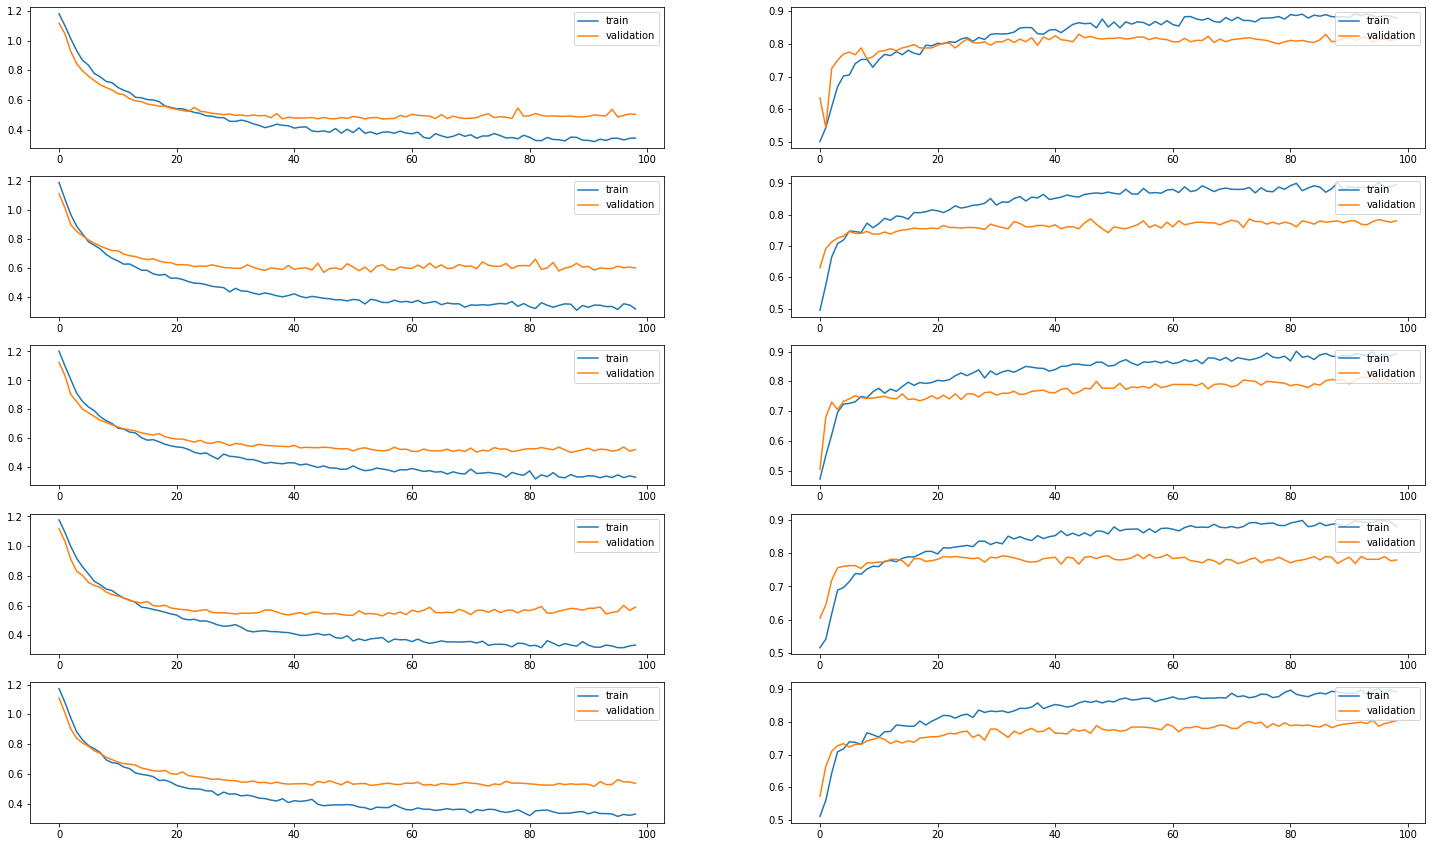

In [13]:
fold_to_show = 0
H = train_history[fold_to_show]

print(H.history.keys())

zoom_start, zoom_end = 0, -1

f, axarr = plt.subplots(len(train_history), 2, figsize=(25, 15))

i=-1
for H in train_history:
    
    i += 1
    
    # "Loss"
    title = 'enc model loss '+str(i)
    axarr[i, 0].plot(H.history['loss'][zoom_start:zoom_end])
    axarr[i, 0].plot(H.history['val_loss'][zoom_start:zoom_end])
#     axarr[i, 0].title(title)
#     axarr[i, 0].ylabel('loss')
#     axarr[i, 0].xlabel('epoch')
    axarr[i, 0].legend(['train', 'validation'], loc='upper right')
#     axarr[i, 0].show()

    # "accuracy"
    title = 'model accuracy '+str(i)
    axarr[i, 1].plot(H.history['accuracy'][zoom_start:zoom_end])
    axarr[i, 1].plot(H.history['val_accuracy'][zoom_start:zoom_end])
#     axarr[i, 1].title(title)
#     axarr[i, 1].ylabel('accuracy')
#     axarr[i, 1].xlabel('epoch')
    axarr[i, 1].legend(['train', 'validation'], loc='upper right')
#     axarr[i, 1].show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


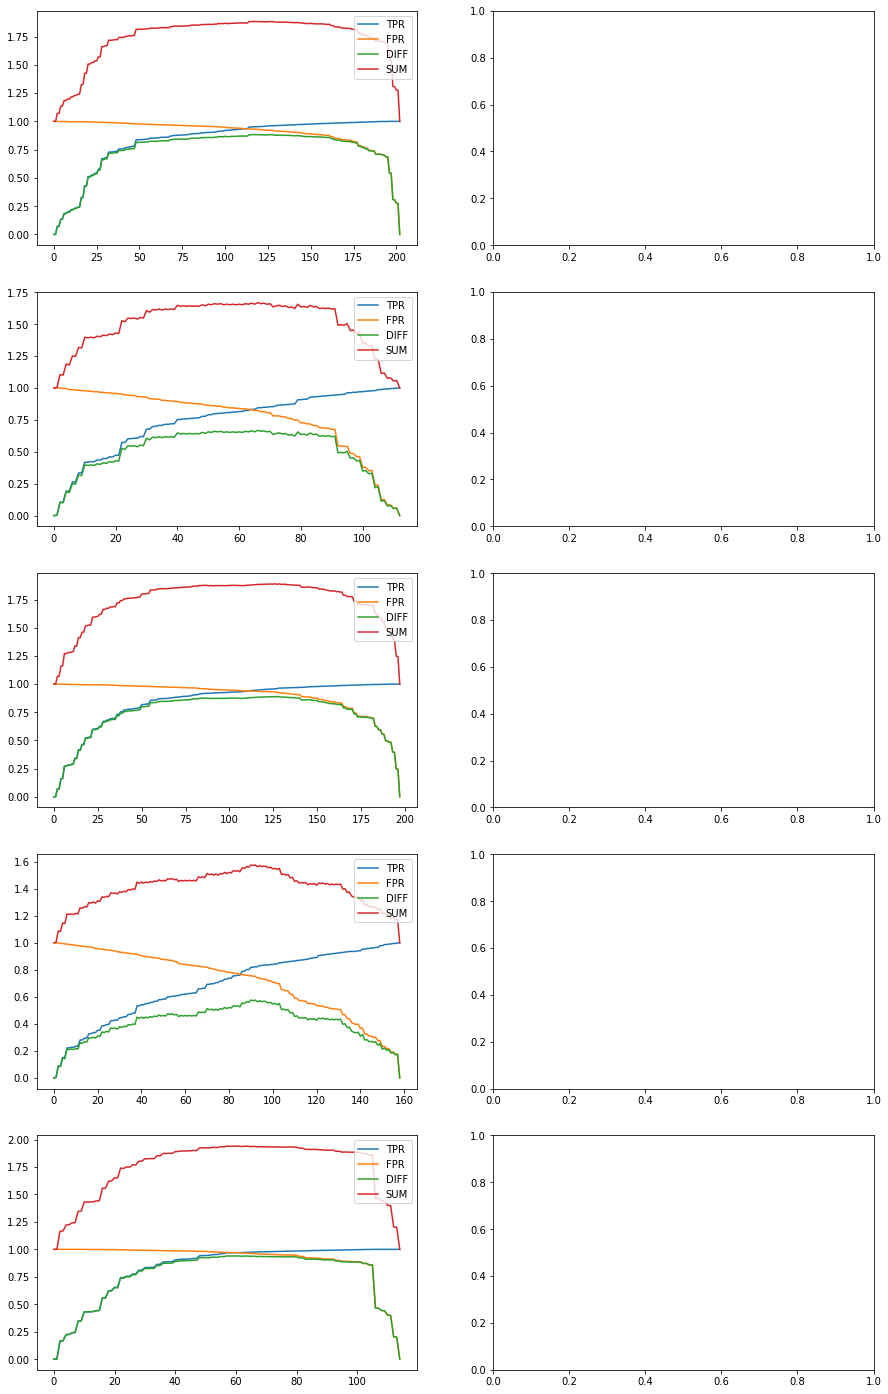

In [14]:
evaluations_df = pd.DataFrame.from_dict(evaluations)

fold_to_show = 0
H = train_history[fold_to_show]

print(H.history.keys())

zoom_start, zoom_end = 0, -1

f, axarr = plt.subplots(len(train_history), 2, figsize=(15, 25))

i=-1
for H in train_history:
    
    i += 1
    
    # "Loss"
    title = 'enc model loss '+str(i)
    axarr[i, 0].plot(evaluations_df['TPR'][i])
    axarr[i, 0].plot(1-evaluations_df['FPR'][i])
    axarr[i, 0].plot(evaluations_df['TPR'][i] - evaluations_df['FPR'][i])
    axarr[i, 0].plot(evaluations_df['TPR'][i] + (1-evaluations_df['FPR'][i]))
    
#     axarr[i, 0].title(title)
#     axarr[i, 0].ylabel('loss')
#     axarr[i, 0].xlabel('epoch')
    axarr[i, 0].legend(['TPR', 'FPR', 'DIFF', 'SUM'], loc='upper right')
#     axarr[i, 0].show()

#     # "accuracy"
#     title = 'model accuracy '+str(i)
#     axarr[i, 1].plot(H.history['accuracy'][zoom_start:zoom_end])
#     axarr[i, 1].plot(H.history['val_accuracy'][zoom_start:zoom_end])
# #     axarr[i, 1].title(title)
# #     axarr[i, 1].ylabel('accuracy')
# #     axarr[i, 1].xlabel('epoch')
#     axarr[i, 1].legend(['train', 'validation'], loc='upper right')
# #     axarr[i, 1].show()

## k-fold Training evaluation

In [15]:
evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Test,0.806464,0.815110,0.875795,0.795127,0.817851,0.613983
Train,0.954132,0.956413,0.989527,0.951716,0.956545,0.908308


In [16]:
evaluations_df.groupby(["Train_Test"]).std().filter(['Accuracy', 
                                                       'Precision', 
                                                       'AUC', 
                                                       'Sensitivity', 
                                                       'Specificity', 
                                                       'MCC'])

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Test,0.017017,0.033984,0.022753,0.019386,0.044176,0.034232
Train,0.016652,0.018746,0.005921,0.015664,0.018886,0.033299


In [17]:
evaluations_df[evaluations_df["Train_Test"] == "Test"]

,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
1,0,Test,0.830189,0.852679,"[0.0, 0.0041841004184100415, 0.104602510460251...","[0.0, 0.0, 0.0, 0.004201680672268907, 0.004201...","[1.9943652, 0.9943652, 0.97093683, 0.97016656,...",0.900759,0.799163,0.861345,0.661730
3,1,Test,0.786164,0.769841,"[0.0, 0.004201680672268907, 0.0882352941176470...","[0.0, 0.0, 0.0, 0.0041841004184100415, 0.00418...","[1.999279, 0.9992791, 0.98784757, 0.98780966, ...",0.840266,0.815126,0.757322,0.573366
5,2,Test,0.815126,0.831858,"[0.0, 0.004201680672268907, 0.1512605042016806...","[0.0, 0.0, 0.0, 0.004201680672268907, 0.004201...","[1.9978275, 0.9978275, 0.9824097, 0.98235875, ...",0.885848,0.789916,0.840336,0.631055
7,3,Test,0.796218,0.790123,"[0.0, 0.004201680672268907, 0.0168067226890756...","[0.0, 0.0, 0.0, 0.004201680672268907, 0.004201...","[1.9985709, 0.9985709, 0.9960167, 0.9955113, 0...",0.869571,0.806723,0.785714,0.592568
9,4,Test,0.804622,0.831050,"[0.0, 0.004201680672268907, 0.2016806722689075...","[0.0, 0.0, 0.0, 0.004201680672268907, 0.004201...","[1.9992073, 0.9992072, 0.98160756, 0.9810433, ...",0.882529,0.764706,0.844538,0.611194


# Independent data

In [18]:
train_features = features
train_labels = labels

In [19]:
##################################################################################
##### read independent data file
##################################################################################
indpe_file_path = os.path.join(input_data_folder, independent_data_file)
indpe_data = pd.read_csv(indpe_file_path, sep='\t', header=None)
indpe_data.columns = ['Sequence', 'name', 'id', 'flag', 'label_original', 'type']
indpe_data.head()
    
##################################################################################
##### Create OHE of sequence
##################################################################################
indpe_data['OHE_Sequence'] = pd.Series([one_hot_encode_nt(val, all_char_dict) 
                                        for val in indpe_data["Sequence"]])

##################################################################################
##### Fix the labels
##################################################################################
indpe_data['label'] = pd.Series([1 if val == 1 else 0 
                                 for val in indpe_data["label_original"]])

##################################################################################
##### Extract features and labels, create folds
##################################################################################

indpe_features = np.array(list(indpe_data['OHE_Sequence']))
indpe_labels = np.array(list(indpe_data['label']))
indpe_labels = indpe_labels.reshape((indpe_labels.shape[0], 1))

input_seq_shape = indpe_features[0].shape

## Using k-fold Models

### Performance of each k-fold model

In [20]:
## create the evaluation data structure for all iterations
indpe_evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    label_pred = pred2label(y_pred)

    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(indpe_labels, label_pred)
    prec = precision_score(indpe_labels,label_pred)
    mcc = matthews_corrcoef(indpe_labels, label_pred)

    conf = confusion_matrix(indpe_labels, label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    fpr, tpr, thresholds = roc_curve(indpe_labels, y_pred)
    auc = roc_auc_score(indpe_labels, y_pred)

    indpe_evaluations["Fold"].append(i)
    indpe_evaluations["Train_Test"].append("Independent")
    indpe_evaluations["Accuracy"].append(acc)
    indpe_evaluations["Precision"].append(prec)
    indpe_evaluations["TPR"].append(tpr)
    indpe_evaluations["FPR"].append(fpr)
    indpe_evaluations["TPR_FPR_Thresholds"].append(thresholds)
    indpe_evaluations["AUC"].append(auc)
    indpe_evaluations["Sensitivity"].append(sens)
    indpe_evaluations["Specificity"].append(spec)
    indpe_evaluations["MCC"].append(mcc)

##################################################################################

indpe_evaluations_df = pd.DataFrame.from_dict(indpe_evaluations)

indpe_evaluations_df_grouped = indpe_evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

indpe_evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.650122,0.265866,0.687975,0.628571,0.654403,0.215788


In [21]:
indpe_evaluations_df

,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,0,Independent,0.664490,0.274892,"[0.0, 0.0049261083743842365, 0.004926108374384...","[0.0, 0.0, 0.0009784735812133072, 0.0009784735...","[1.9974124, 0.9974125, 0.9933515, 0.9914957, 0...",0.689824,0.625616,0.672211,0.228483
1,1,Independent,0.619592,0.248566,"[0.0, 0.0049261083743842365, 0.009852216748768...","[0.0, 0.0, 0.0, 0.0029354207436399216, 0.00293...","[1.9992204, 0.9992204, 0.99838006, 0.9969818, ...",0.683673,0.640394,0.615460,0.192330
2,2,Independent,0.666939,0.268623,"[0.0, 0.0049261083743842365, 0.004926108374384...","[0.0, 0.0, 0.0009784735812133072, 0.0009784735...","[1.9993864, 0.9993864, 0.9964683, 0.9960223, 0...",0.681283,0.586207,0.682975,0.208312
3,3,Independent,0.639184,0.260521,"[0.0, 0.0049261083743842365, 0.004926108374384...","[0.0, 0.0, 0.0009784735812133072, 0.0009784735...","[1.9991288, 0.99912876, 0.9976283, 0.99653554,...",0.686252,0.640394,0.638943,0.211390
4,4,Independent,0.660408,0.276730,"[0.0, 0.0049261083743842365, 0.004926108374384...","[0.0, 0.0, 0.0019569471624266144, 0.0019569471...","[1.9993086, 0.9993086, 0.99769515, 0.9973437, ...",0.698842,0.650246,0.662427,0.238426


### Mean score with k-fold models

In [22]:
## create the evaluation data structure for all iterations
indpe_evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

total_pred = np.zeros(indpe_labels.shape)
all_preds = []

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    total_pred += y_pred
    all_preds.append(y_pred)
    
total_pred = total_pred / n_fold
label_pred = pred2label(total_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, total_pred)
auc = roc_auc_score(indpe_labels, total_pred)

indpe_evaluations["Fold"].append(i)
indpe_evaluations["Train_Test"].append("Independent")
indpe_evaluations["Accuracy"].append(acc)
indpe_evaluations["Precision"].append(prec)
indpe_evaluations["TPR"].append(tpr)
indpe_evaluations["FPR"].append(fpr)
indpe_evaluations["TPR_FPR_Thresholds"].append(thresholds)
indpe_evaluations["AUC"].append(auc)
indpe_evaluations["Sensitivity"].append(sens)
indpe_evaluations["Specificity"].append(spec)
indpe_evaluations["MCC"].append(mcc)

##################################################################################

indpe_evaluations_df = pd.DataFrame.from_dict(indpe_evaluations)

indpe_evaluations_df_grouped = indpe_evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

indpe_evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.665306,0.275488,0.697979,0.625616,0.67319,0.229332


In [23]:
indpe_evaluations_df

,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,4,Independent,0.665306,0.275488,"[0.0, 0.0049261083743842365, 0.004926108374384...","[0.0, 0.0, 0.0009784735812133072, 0.0009784735...","[1.99889132976532, 0.9988913297653198, 0.99537...",0.697979,0.625616,0.67319,0.229332


### Voting score with k-fold models

In [24]:
## create the evaluation data structure for all iterations
indpe_evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

total_pred = np.zeros(indpe_labels.shape)
all_preds = []

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    vote_pred = pred2label(y_pred)
    total_pred += vote_pred
    all_preds.append(vote_pred)
    
total_pred = total_pred / n_fold
label_pred = pred2label(total_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, total_pred)
auc = roc_auc_score(indpe_labels, total_pred)

indpe_evaluations["Train_Test"].append("Independent")
indpe_evaluations["Accuracy"].append(acc)
indpe_evaluations["Precision"].append(prec)
indpe_evaluations["TPR"].append(tpr)
indpe_evaluations["FPR"].append(fpr)
indpe_evaluations["TPR_FPR_Thresholds"].append(thresholds)
indpe_evaluations["AUC"].append(auc)
indpe_evaluations["Sensitivity"].append(sens)
indpe_evaluations["Specificity"].append(spec)
indpe_evaluations["MCC"].append(mcc)

##################################################################################

indpe_evaluations_df = pd.DataFrame.from_dict(indpe_evaluations)

indpe_evaluations_df_grouped = indpe_evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

indpe_evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.663673,0.272331,0.686199,0.615764,0.67319,0.221963


In [25]:
indpe_evaluations_df

,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,Independent,0.663673,0.272331,"[0.0, 0.4876847290640394, 0.5615763546798029, ...","[0.0, 0.20645792563600782, 0.2837573385518591,...","[2.0, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0]",0.686199,0.615764,0.67319,0.221963


## Using New Model

Train model on full data from training. Predict and evaluate on Independent data.

In [26]:
pos_indexes = np.where(indpe_labels==1)[0]
neg_indexes = np.random.permutation(np.where(indpe_labels==0)[0])[0:pos_indexes.shape[0]]
indpe_val_indexes = np.concatenate((pos_indexes, neg_indexes))

In [27]:
model = DLNN_CORENup(input_seq_shape = input_seq_shape)
    
## Define the model callbacks for early stopping and saving the model. Then train model
current_model_path = os.path.join(modelPath, "_fullModel.hdf5")
modelCallbacks = [
    tf.keras.callbacks.ModelCheckpoint(current_model_path,
                                       monitor = monitor, verbose = 1, save_best_only = True, 
                                       save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
]

# adding random shuffling of the dataset for training purpose
index_arr = np.arange(train_features.shape[0])
index_arr = np.random.permutation(index_arr)

H = model.fit(x = train_features[index_arr], y = train_labels[index_arr], 
                    batch_size = batch_size, epochs = epochs, 
                    verbose = 1, callbacks = modelCallbacks, 
                    validation_data = (indpe_features[indpe_val_indexes], indpe_labels[indpe_val_indexes]))
# H = model.fit(x = train_features[index_arr], y = train_labels[index_arr], 
#                     batch_size = batch_size, epochs = epochs, 
#                     verbose = 1, callbacks = modelCallbacks, 
#                     validation_data = (indpe_features, indpe_labels))
# model.fit(x = train_features[index_arr], y = train_labels[index_arr], batch_size = batch_size, epochs = epochs, verbose = 1, 
#           callbacks = modelCallbacks, validation_split = 0.2)

model = tf.keras.models.load_model(current_model_path)

Epoch 1/100
75/75 [==============================] - ETA: 0s - loss: 1.1825 - accuracy: 0.4983
Epoch 1: val_accuracy improved from -inf to 0.49261, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_2\5fold\models\_fullModel.hdf5
75/75 [==============================] - 4s 23ms/step - loss: 1.1825 - accuracy: 0.4983 - val_loss: 1.1141 - val_accuracy: 0.4926
Epoch 2/100
72/75 [===========================>..] - ETA: 0s - loss: 1.0724 - accuracy: 0.5530
Epoch 2: val_accuracy improved from 0.49261 to 0.56404, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_2\5fold\models\_fullModel.hdf5
75/75 [==============================] - 1s 12ms/step - loss: 1.0709 - accuracy: 0.5542 - val_loss: 1.0415 - val_accuracy: 0.5640
Epoch 3/100
74/75 [============================>.] - ETA: 0s - loss: 0.9487 - accuracy: 0.6571
Epoch 3: val_accuracy improved from 0.56404 to 0.59606, saving model to Results\NT_Site_PredNTS_Classification_DLN

71/75 [===========================>..] - ETA: 0s - loss: 0.4688 - accuracy: 0.8248
Epoch 27: val_accuracy did not improve from 0.62069
75/75 [==============================] - 1s 11ms/step - loss: 0.4669 - accuracy: 0.8262 - val_loss: 0.8377 - val_accuracy: 0.6084
Epoch 28/100
75/75 [==============================] - ETA: 0s - loss: 0.4602 - accuracy: 0.8191
Epoch 28: val_accuracy did not improve from 0.62069
75/75 [==============================] - 1s 11ms/step - loss: 0.4602 - accuracy: 0.8191 - val_loss: 0.8619 - val_accuracy: 0.6133
Epoch 29/100
74/75 [============================>.] - ETA: 0s - loss: 0.4598 - accuracy: 0.8222
Epoch 29: val_accuracy improved from 0.62069 to 0.62315, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_2\5fold\models\_fullModel.hdf5
75/75 [==============================] - 1s 12ms/step - loss: 0.4603 - accuracy: 0.8224 - val_loss: 0.8239 - val_accuracy: 0.6232
Epoch 30/100
75/75 [==============================] - ETA:

73/75 [============================>.] - ETA: 0s - loss: 0.3954 - accuracy: 0.8506
Epoch 55: val_accuracy did not improve from 0.63054
75/75 [==============================] - 1s 10ms/step - loss: 0.3935 - accuracy: 0.8514 - val_loss: 0.8874 - val_accuracy: 0.6256
Epoch 56/100
73/75 [============================>.] - ETA: 0s - loss: 0.3935 - accuracy: 0.8583
Epoch 56: val_accuracy did not improve from 0.63054
75/75 [==============================] - 1s 10ms/step - loss: 0.3921 - accuracy: 0.8589 - val_loss: 0.9035 - val_accuracy: 0.6281
Epoch 57/100
73/75 [============================>.] - ETA: 0s - loss: 0.3891 - accuracy: 0.8604
Epoch 57: val_accuracy improved from 0.63054 to 0.63793, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_2\5fold\models\_fullModel.hdf5
75/75 [==============================] - 1s 11ms/step - loss: 0.3861 - accuracy: 0.8619 - val_loss: 0.9435 - val_accuracy: 0.6379
Epoch 58/100
73/75 [============================>.] - ETA:

Epoch 84/100
72/75 [===========================>..] - ETA: 0s - loss: 0.3619 - accuracy: 0.8724
Epoch 84: val_accuracy did not improve from 0.64778
75/75 [==============================] - 1s 11ms/step - loss: 0.3605 - accuracy: 0.8732 - val_loss: 0.9902 - val_accuracy: 0.6182
Epoch 85/100
72/75 [===========================>..] - ETA: 0s - loss: 0.3450 - accuracy: 0.8828
Epoch 85: val_accuracy did not improve from 0.64778
75/75 [==============================] - 1s 10ms/step - loss: 0.3433 - accuracy: 0.8829 - val_loss: 1.0133 - val_accuracy: 0.6281
Epoch 86/100
73/75 [============================>.] - ETA: 0s - loss: 0.3679 - accuracy: 0.8737
Epoch 86: val_accuracy did not improve from 0.64778
75/75 [==============================] - 1s 10ms/step - loss: 0.3661 - accuracy: 0.8749 - val_loss: 1.0242 - val_accuracy: 0.6379
Epoch 87/100
73/75 [============================>.] - ETA: 0s - loss: 0.3352 - accuracy: 0.8883
Epoch 87: val_accuracy did not improve from 0.64778
75/75 [===========

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


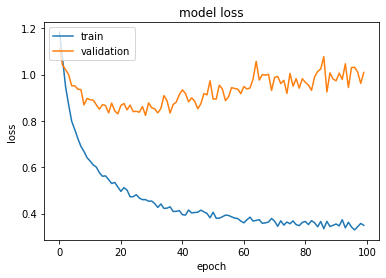

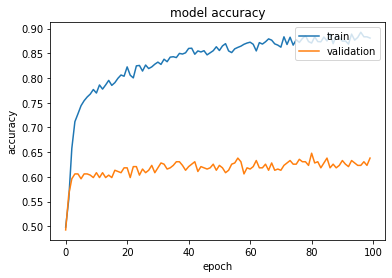

In [28]:
print(H.history.keys())

# "Loss"
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "accuracy"
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


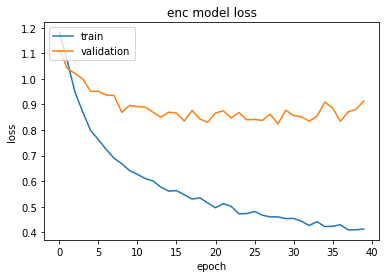

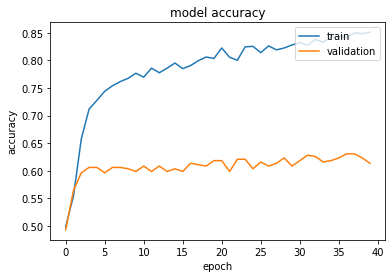

In [29]:
print(H.history.keys())

zoom_start, zoom_end = 0, 40

# "Loss"
plt.plot(H.history['loss'][zoom_start:zoom_end])
plt.plot(H.history['val_loss'][zoom_start:zoom_end])
plt.title('enc model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "accuracy"
plt.plot(H.history['accuracy'][zoom_start:zoom_end])
plt.plot(H.history['val_accuracy'][zoom_start:zoom_end])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [30]:
## create the evaluation data structure for all iterations
indpe_evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

y_pred = model.predict(indpe_features)
label_pred = pred2label(y_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, y_pred)
auc = roc_auc_score(indpe_labels, y_pred)

indpe_evaluations["Train_Test"].append("Independent")
indpe_evaluations["Accuracy"].append(acc)
indpe_evaluations["Precision"].append(prec)
indpe_evaluations["TPR"].append(tpr)
indpe_evaluations["FPR"].append(fpr)
indpe_evaluations["TPR_FPR_Thresholds"].append(thresholds)
indpe_evaluations["AUC"].append(auc)
indpe_evaluations["Sensitivity"].append(sens)
indpe_evaluations["Specificity"].append(spec)
indpe_evaluations["MCC"].append(mcc)

##################################################################################

indpe_evaluations_df = pd.DataFrame.from_dict(indpe_evaluations)

indpe_evaluations_df_grouped = indpe_evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

indpe_evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.697959,0.29484,0.697444,0.591133,0.719178,0.244961


In [31]:
indpe_evaluations_df

,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,Independent,0.697959,0.29484,"[0.0, 0.0049261083743842365, 0.004926108374384...","[0.0, 0.0, 0.0029354207436399216, 0.0029354207...","[1.9987288, 0.9987287, 0.9965655, 0.9964671, 0...",0.697444,0.591133,0.719178,0.244961
